# Building 1D Rydberg Crystals

The following notebook shows a study of many-body dynamics on a 1D system. It is based on [1707.04344](https://arxiv.org/abs/1707.04344). The authors of that paper studied the preparation of symmetry-breaking states in antiferromagnetic Ising chains, by tuning the interaction and driving parameters accross the phase diagram. In this notebook, we reproduce some results of this paper. Since this is a particular experiment not based on certified devices, we will use the `MockDevice` class to allow for a wide range of configuration settings.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qutip

from pulser import Pulse, Sequence, Register
from pulser.simulation import Simulation
from pulser.waveforms import CompositeWaveform, RampWaveform, ConstantWaveform
from pulser.devices import MockDevice

## 1. Rydberg Blockade at Resonant Driving

We first consider clusters of $1, 2$ and $3$ atoms under resonant ($\delta = 0$) driving. If all the atoms are placed within each other's blockade volume, only one excitation per group will be possible at a time. The Rabi frequency will be enhanced by $\sqrt{N}$

In [2]:
def occupation(reg, j):
    r = qutip.basis(2, 0)
    N = len(reg.qubits)
    prod = [qutip.qeye(2) for _ in range(N)]
    prod[j] = r * r.dag()
    return qutip.tensor(prod)

Given a value of the maximum Rabi Frequency applied to the atoms, we can calculate the corresponding blockade radius using the `rydberg_blockade_radius()` method from `MockDevice`. We use this to arrange clusters of atoms which will experience this blockade effect:

In [3]:
Omega_max = 2 * 2 * np.pi
R_blockade = MockDevice.rydberg_blockade_radius(Omega_max)
print(f"Blockade Radius is: {R_blockade}µm.")
groups = 3


def blockade_cluster(N):

    atom_coords = [
        ((R_blockade / N) * x + 40 * group, 0)
        for group in range(groups)
        for x in range(1, N + 1)
    ]
    reg = Register.from_coordinates(atom_coords, prefix="q")
    reg.draw(
        blockade_radius=R_blockade, draw_half_radius=True, draw_graph=False
    )

    resonant_pulse = Pulse.ConstantPulse(1500, Omega_max, 0.0, 0.0)

    seq = Sequence(reg, MockDevice)
    seq.declare_channel("ising", "rydberg_global")
    seq.add(resonant_pulse, "ising")

    simul = Simulation(seq, sampling_rate=0.7)

    obs = [
        sum(occupation(reg, j) for j in range(i, i + N))
        for i in range(0, groups * N, N)
    ]

    res = simul.run(progress_bar=True, method="bdf")
    return res.expect(obs)

Blockade Radius is: 8.692279598222772µm.


Next we run `blockade_cluster(N)`, which runs the simulation, for clusters of sizes $N \in \{1,2,3\}$:

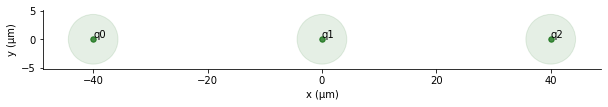

10.1%. Run time:   0.02s. Est. time left: 00:00:00:00
20.1%. Run time:   0.03s. Est. time left: 00:00:00:00
30.1%. Run time:   0.05s. Est. time left: 00:00:00:00
40.1%. Run time:   0.07s. Est. time left: 00:00:00:00
50.0%. Run time:   0.10s. Est. time left: 00:00:00:00
60.0%. Run time:   0.12s. Est. time left: 00:00:00:00
70.0%. Run time:   0.15s. Est. time left: 00:00:00:00
80.0%. Run time:   0.19s. Est. time left: 00:00:00:00
90.0%. Run time:   0.24s. Est. time left: 00:00:00:00
Total run time:   0.30s


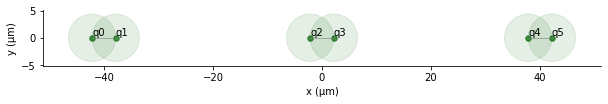

10.1%. Run time:   0.03s. Est. time left: 00:00:00:00
20.1%. Run time:   0.07s. Est. time left: 00:00:00:00
30.1%. Run time:   0.12s. Est. time left: 00:00:00:00
40.1%. Run time:   0.16s. Est. time left: 00:00:00:00
50.0%. Run time:   0.21s. Est. time left: 00:00:00:00
60.0%. Run time:   0.25s. Est. time left: 00:00:00:00
70.0%. Run time:   0.29s. Est. time left: 00:00:00:00
80.0%. Run time:   0.33s. Est. time left: 00:00:00:00
90.0%. Run time:   0.38s. Est. time left: 00:00:00:00
Total run time:   0.43s


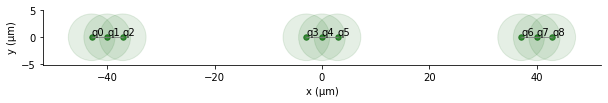

10.1%. Run time:   0.43s. Est. time left: 00:00:00:03
20.1%. Run time:   0.88s. Est. time left: 00:00:00:03
30.1%. Run time:   1.35s. Est. time left: 00:00:00:03
40.1%. Run time:   1.83s. Est. time left: 00:00:00:02
50.0%. Run time:   2.30s. Est. time left: 00:00:00:02
60.0%. Run time:   2.77s. Est. time left: 00:00:00:01
70.0%. Run time:   3.26s. Est. time left: 00:00:00:01
80.0%. Run time:   3.74s. Est. time left: 00:00:00:00
90.0%. Run time:   4.21s. Est. time left: 00:00:00:00
Total run time:   4.68s


In [4]:
data = [blockade_cluster(N) for N in [1, 2, 3]]

We now plot the probability that a Rydberg state withing the cluster is occupied (by summing the expectation values of the $|r\rangle\langle r|_i$ operators for each cluster) as it evolves in time, revealing the Rabi frequency of each configuration:

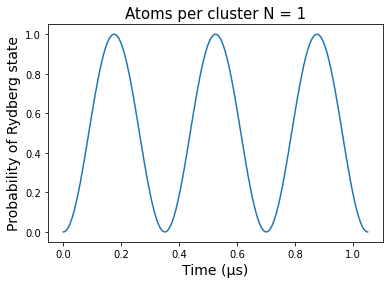

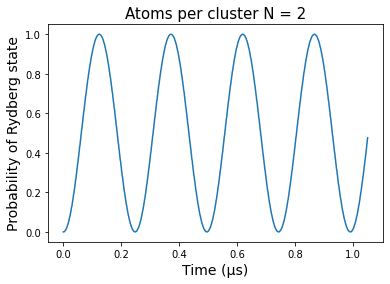

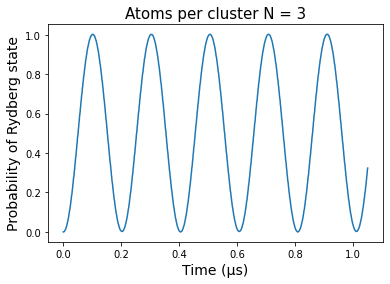

In [5]:
for N, expectation in enumerate(data):
    plt.xlabel("Time (µs)", fontsize=14)
    plt.ylabel("Probability of Rydberg state", fontsize=14)
    plt.title(f"Atoms per cluster N = {N+1}", fontsize=15)
    avg = sum(expectation) / groups
    plt.plot(np.arange(len(avg)) / 1000, avg)
    plt.show()

Only one excitation will be shared between the atoms on each cluster. Notice how the Rabi frequency increases by a factor of $\sqrt{N}$ 

## 2. Ordered Crystalline phases

The pulse sequence that we will prepare is based on the following parameters:

In [6]:
# Parameters in rad/µs and ns
delta_0 = -6 * 2 * np.pi
delta_f = 10 * 2 * np.pi
Omega_max = 2 * 2 * np.pi
t_rise = 500
t_stop = 4500
t_end = 5000

We calculate the blockade radius from the maximal applied Rabi frequency:

Blockade Radius is: 8.692279598222772µm.


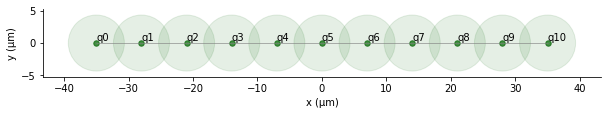

In [7]:
R_blockade = MockDevice.rydberg_blockade_radius(Omega_max)
a = 7.0

reg = Register.rectangle(1, 11, spacing=a, prefix="q")
print(f"Blockade Radius is: {R_blockade}µm.")
reg.draw(blockade_radius=R_blockade, draw_half_radius=True)

Create the pulses using Pulser objects:

In [8]:
hold = ConstantWaveform(t_rise, delta_0)
excite = RampWaveform(t_stop - t_rise, delta_0, delta_f)
sweep = Pulse.ConstantAmplitude(
    Omega_max, CompositeWaveform(hold, excite), 0.0
)
stay = Pulse.ConstantPulse(t_end - t_stop, 0.0, delta_f, 0.0)

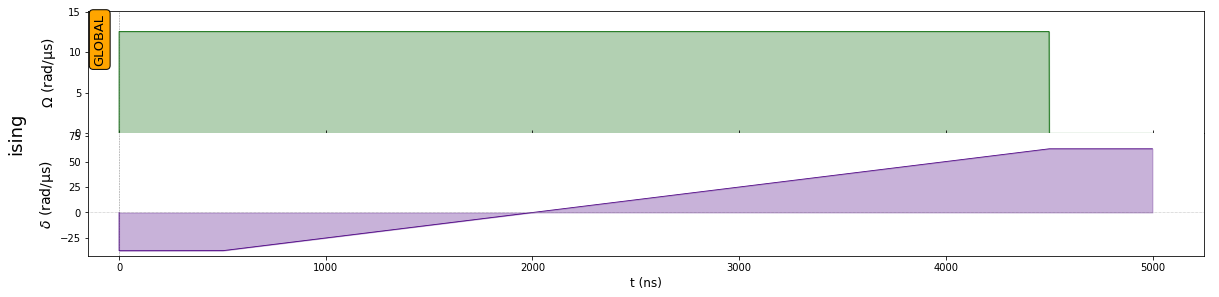

In [9]:
seq = Sequence(reg, MockDevice)
seq.declare_channel("ising", "rydberg_global")

seq.add(sweep, "ising")
seq.add(stay, "ising")

# print(seq)
seq.draw()

The pulse sequence we just created corresponds a path in the Phase space of the ground state, which we represent schematically with the following function:

In [10]:
def phase_diagram(seq):
    ratio = []
    for x in seq._schedule["ising"]:
        if isinstance(x.type, Pulse):
            ratio += list(x.type.detuning.samples / Omega_max)

    fig, ax = plt.subplots()
    ax.grid(True, which="both")

    ax.set_ylabel(r"Interaction Range $R_b/a$", fontsize=14)
    ax.set_xlabel(r"Detuning $\delta/\Omega$", fontsize=14)
    ax.set_xlim(-4, 6)
    ax.set_ylim(0, 3.2)
    ax.axhline(y=0, color="k")
    ax.axvline(x=0, color="k")

    y = np.arange(0.0, 5, 0.01)
    x = 2 * (0.6 + 8 * (y - 1.2) ** 2)
    ax.fill_between(x, y, alpha=0.4)

    y = np.arange(0.0, 5, 0.01)
    x = 2 * (0.8 + 50 * (y - 2.45) ** 2)
    ax.fill_between(x, y, alpha=0.4)

    y = np.arange(0.0, 5, 0.01)
    x = 2 * (1.0 + 170 * (y - 3.06) ** 2)
    ax.fill_between(x, y, alpha=0.4)

    ax.plot(np.array(ratio), np.full(len(ratio), R_blockade / a), "red", lw=2)
    plt.show()

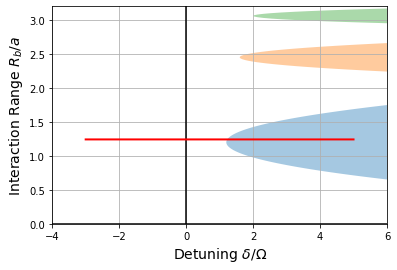

In [11]:
phase_diagram(seq)

### 2.1 Simulation

We run our simulation, for a list of observables corresponding to $|r\rangle \langle r|_j$ for each atom in the register:

In [12]:
simul = Simulation(seq, sampling_rate=0.1)

occup_list = [occupation(reg, j) for j in range(len(reg.qubits))]

res = simul.run(progress_bar=True)
occupations = res.expect(occup_list)

10.2%. Run time:   0.21s. Est. time left: 00:00:00:01
20.2%. Run time:   0.47s. Est. time left: 00:00:00:01
30.1%. Run time:   0.77s. Est. time left: 00:00:00:01
40.1%. Run time:   1.03s. Est. time left: 00:00:00:01
50.1%. Run time:   1.26s. Est. time left: 00:00:00:01
60.1%. Run time:   1.47s. Est. time left: 00:00:00:00
70.1%. Run time:   1.73s. Est. time left: 00:00:00:00
80.0%. Run time:   2.04s. Est. time left: 00:00:00:00
90.0%. Run time:   2.37s. Est. time left: 00:00:00:00
Total run time:   2.68s


The following function plots the evolution of the expectation values with respect to time:

In [13]:
def plot_evolution(results):
    plt.figure(figsize=(10, 5))
    plt.xlabel("Time (µs)", fontsize=14)
    plt.ylabel("Rydberg Occupation Probabilty", fontsize=14)
    for expv in results:
        plt.plot(np.arange(len(expv)) / 1000, expv)

    plt.show()

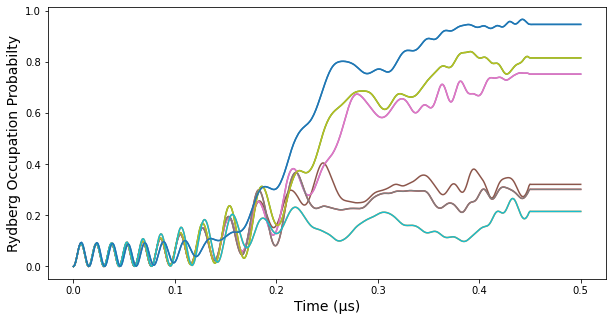

In [14]:
plot_evolution(occupations)

We finally plot the probability of occupation of the Rydberg level with respect to the values of detuning, for each atom in the array:

In [15]:
def heat_detuning(data, start, end):
    N = len(reg.qubits)
    time_window = []
    x = []
    detunings = simul.samples["Global"]["ground-rydberg"]["det"][
        [int(1000 * t) for t in simul.sampling_times]
    ]

    for t, d in enumerate(detunings):
        if start <= d <= end:
            time_window.append(t)
            x.append(d / (2 * np.pi))

    y = np.arange(1, N + 1)

    X, Y = np.meshgrid(x, y)
    Z = np.array(data)[:, time_window]

    plt.figure(figsize=(14, 3))
    plt.pcolormesh(X, Y, Z, cmap="hot", shading="auto")
    plt.xlabel("Detuning/2π (MHz)", fontsize=14)
    plt.ylabel("Atom in array", fontsize=14)
    plt.yticks(range(1, N + 1), [f"q{i}" for i in range(N)], va="center")
    plt.colorbar(fraction=0.047, pad=0.015)

    plt.show()

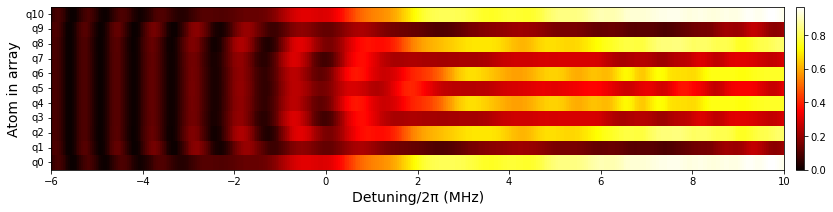

In [16]:
heat_detuning(occupations, delta_0, delta_f)

### 2.2 Rydberg Crystals: $Z_3$ Order

To arrive at a different phase, we reduce the interatomic distance $a$, thus increasing the interaction range between the atoms. This will lead to a $Z_3$ ordered phase: 

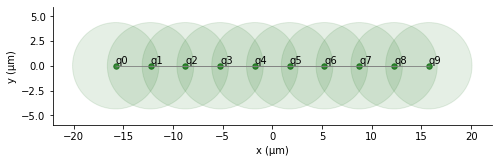

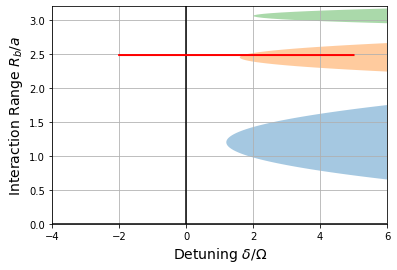

10.3%. Run time:   0.86s. Est. time left: 00:00:00:07
20.3%. Run time:   1.83s. Est. time left: 00:00:00:07
30.2%. Run time:   2.69s. Est. time left: 00:00:00:06
40.2%. Run time:   3.52s. Est. time left: 00:00:00:05
50.2%. Run time:   4.39s. Est. time left: 00:00:00:04
60.1%. Run time:   5.23s. Est. time left: 00:00:00:03
70.1%. Run time:   6.06s. Est. time left: 00:00:00:02
80.1%. Run time:   6.90s. Est. time left: 00:00:00:01
90.0%. Run time:   7.73s. Est. time left: 00:00:00:00
Total run time:   8.52s


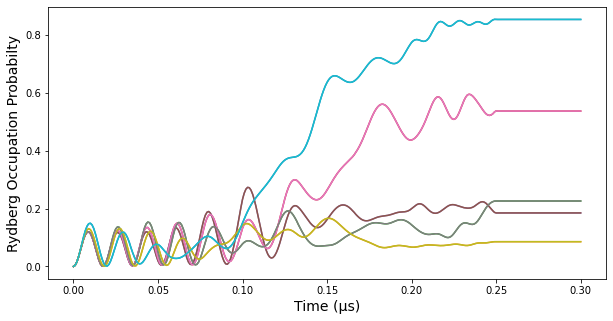

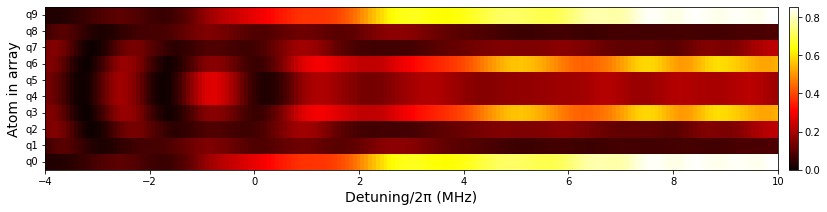

In [17]:
a = 3.5
reg = Register.rectangle(1, 10, spacing=a, prefix="q")

delta_0 = -4 * 2 * np.pi
delta_f = 10 * 2 * np.pi
Omega_max = 2.0 * 2 * np.pi  # btw 1.8-2 * 2pi MHz
t_rise = 600
t_stop = 2500
t_end = 3000
R_blockade = MockDevice.rydberg_blockade_radius(Omega_max)
reg.draw(blockade_radius=R_blockade, draw_half_radius=True)

#
hold = ConstantWaveform(t_rise, delta_0)
excite = RampWaveform(t_stop - t_rise, delta_0, delta_f)
sweep = Pulse.ConstantAmplitude(
    Omega_max, CompositeWaveform(hold, excite), 0.0
)
stay = Pulse.ConstantPulse(t_end - t_stop, 0.0, delta_f, 0.0)

#
seq = Sequence(reg, MockDevice)
seq.declare_channel("ising", "rydberg_global")

seq.add(sweep, "ising")
seq.add(stay, "ising")

# print(seq)
# seq.draw()
phase_diagram(seq)

simul = Simulation(seq, sampling_rate=0.1)

occup_list = [occupation(reg, j) for j in range(simul._size)]

res = simul.run(progress_bar=True, method="bdf")

occupations = res.expect(occup_list)

plot_evolution(occupations)
heat_detuning(occupations, delta_0, delta_f)

### 2.3 Rydberg Crystals: $Z_4$ Order

Decreasing even more the interatomic distance leads to a $Z_4$ order. The magnitude of the Rydberg interaction with respect to that of the applied pulses means our solver has to control terms with a wider range, thus leading to longer simulation times:

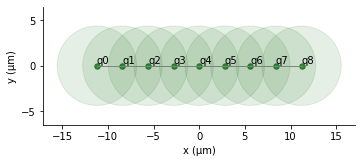

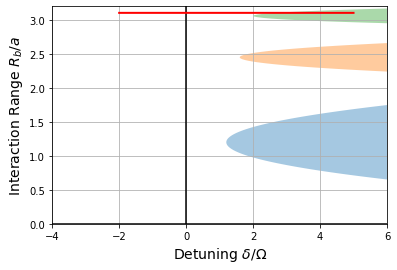

10.0%. Run time:   1.94s. Est. time left: 00:00:00:17
20.0%. Run time:   4.00s. Est. time left: 00:00:00:15
30.0%. Run time:   6.26s. Est. time left: 00:00:00:14
40.0%. Run time:   9.07s. Est. time left: 00:00:00:13
50.0%. Run time:  11.38s. Est. time left: 00:00:00:11
60.0%. Run time:  13.30s. Est. time left: 00:00:00:08
70.0%. Run time:  14.95s. Est. time left: 00:00:00:06
80.0%. Run time:  16.52s. Est. time left: 00:00:00:04
90.0%. Run time:  18.18s. Est. time left: 00:00:00:02
Total run time:  20.73s


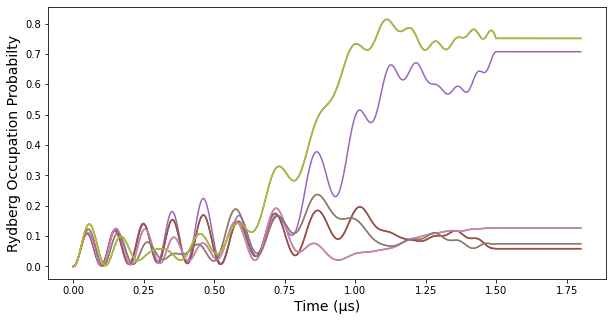

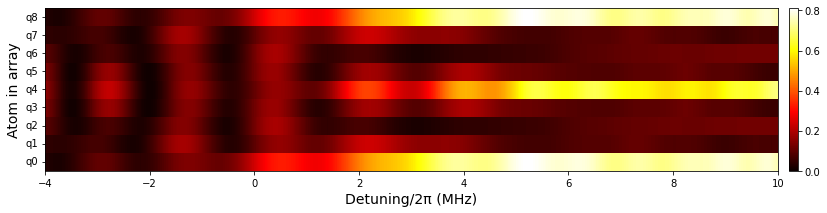

In [18]:
a = 2.8
reg = Register.rectangle(1, 9, spacing=a, prefix="q")

# Parameters in rad/µs and ns

delta_0 = -4 * 2 * np.pi
delta_f = 10 * 2 * np.pi
Omega_max = 2.0 * 2 * np.pi  # btw 1.8-2 2pi*MHz
t_rise = 600
t_stop = 2500
t_end = 3000
R_blockade = MockDevice.rydberg_blockade_radius(Omega_max)
reg.draw(blockade_radius=R_blockade, draw_half_radius=True)

#
hold = ConstantWaveform(t_rise, delta_0)
excite = RampWaveform(t_stop - t_rise, delta_0, delta_f)
sweep = Pulse.ConstantAmplitude(
    Omega_max, CompositeWaveform(hold, excite), 0.0
)
stay = Pulse.ConstantPulse(t_end - t_stop, 0.0, delta_f, 0.0)

#
seq = Sequence(reg, MockDevice)
seq.declare_channel("ising", "rydberg_global")

seq.add(sweep, "ising")
seq.add(stay, "ising")

phase_diagram(seq)

simul = Simulation(seq, sampling_rate=0.6)

occup_list = [occupation(reg, j) for j in range(simul._size)]

#
res = simul.run(progress_bar=True, method="bdf")
occupations = res.expect(occup_list)

plot_evolution(occupations)
heat_detuning(occupations, delta_0, delta_f)